# 2 - Limpeza de dados


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import duckdb
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

*`Carregamento dos dados`*

In [28]:
# URL da API do NYC Open Data (Socrata API)
url = "https://data.cityofnewyork.us/resource/uip8-fykc.json"
# Carregar dados
df = pd.read_json(url, dtype={'arrest_key': str})
pure_df = pd.read_json(url, dtype={'arrest_key': str})
# Remove colunas automáticas do portal NYC Open Data
df = df.loc[:, ~df.columns.str.startswith(':@computed_region_')]

Análise da qualidade do código


In [29]:
#Análise de dados faltantes
print("\n🔍 Análise de Dados Faltantes:")
missing_data = pd.DataFrame({
    'Coluna': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
)
print(missing_data)


🔍 Análise de Dados Faltantes:
                Coluna  Missing_Count  Missing_Percent
law_cat_cd  law_cat_cd              2              0.2


Através do código acima podemos afirmar que em todo o dataset a colunar "law_cat_cd" é a única que possui dados faltantes,
e bem poucos, apenas 2





In [30]:
df['law_cat_cd'].fillna('UNKNOW',inplace=True)

No código acima é adicionado "UNKNOW" para os campos que não possuem valor, como "law_cat_cd" é um campo de texto acredito que essa é uma boa abordagem para tirar os valores nulos




## DETECTAR OUTLIERS

Vamo usar o método IQR para detectar outliers

In [31]:
def detectar_outliers_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    outliers = df[(df[coluna] < lim_inf) | (df[coluna] > lim_sup)]
    print(f"Coluna: {coluna}")
    print(f"Outliers encontrados: {len(outliers)}")
    return outliers

# Exemplo:
outliers_precinct = detectar_outliers_iqr(df, 'arrest_precinct')


Coluna: arrest_precinct
Outliers encontrados: 0


Pelo código acima podemos notar que não encontramos nenhum outlier

## DETECTAR INCONSISTÊNCIAS

cada precinct deveria mapear para um borough único

In [32]:
precinct_boros = df.groupby('arrest_precinct')['arrest_boro'].nunique()
inconsistentes = precinct_boros[precinct_boros > 1]
print(inconsistentes)
df[df['arrest_precinct'] == 114][['arrest_precinct', 'arrest_boro']].drop_duplicates()



arrest_precinct
114    2
Name: arrest_boro, dtype: int64


,arrest_precinct,arrest_boro
5,114,Q
698,114,M


Problema identificado que a delegacia 114 aparece associado a dois distritos diferentes, a regra é que cada distrito tem uma delegacia associada.

No caso o distritor 114 deveria referencias ao Queens, no código abaixo será arrumado isso

In [33]:
# Corrigir o borough do precinct 114
df.loc[df['arrest_precinct'] == 114, 'arrest_boro'] = 'Q'


### Nova seção PADRONIZAÇÃO

O dataset ja está seguindo uma boa padronização portanto não será necessários tomar ações

# SQLS E GRÁFICOS


📊 SQL 1: DADOS FALTANTES (Situação Original)
--------------------------------------------------------------------------------

💡 INTERPRETAÇÃO:
Esta consulta identifica que a coluna 'law_cat_cd' possui 2 valores nulos (0.2%)
representando categorias de lei não registradas em algumas prisões.


📊 SQL 2: INCONSISTÊNCIAS - PRECINCTS COM MÚLTIPLOS BOROUGHS
--------------------------------------------------------------------------------

💡 INTERPRETAÇÃO:
Esta consulta revela que o precinct 114 está incorretamente associado a
múltiplos boroughs (distritos), violando a regra de negócio que estabelece
uma relação 1:1 entre delegacia e distrito.


📊 SQL 3: ANÁLISE DETALHADA DO PRECINCT 114
--------------------------------------------------------------------------------

💡 INTERPRETAÇÃO:
Esta análisemost ra a distribuição das associações do precinct 114 com
diferentes boroughs, permitindo identificar qual é o borough correto
(aquele com maior frequência).


📊 SQL 4: VALIDAÇÃO PÓS-CORREÇÃO
-----

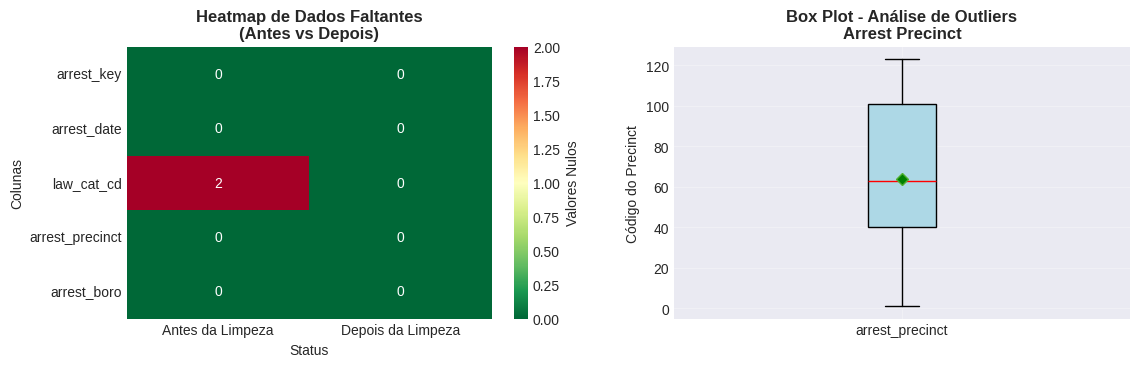

In [44]:
# SQL 1: Análise de dados faltantes ANTES da correção
sql_missing_before = """
SELECT
    'law_cat_cd' as coluna,
    COUNT(*) as total_registros,
    SUM(CASE WHEN law_cat_cd IS NULL THEN 1 ELSE 0 END) as valores_nulos,
    ROUND(100.0 * SUM(CASE WHEN law_cat_cd IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) as percentual_nulos
FROM df
"""

print("\n📊 SQL 1: DADOS FALTANTES (Situação Original)")
print("-" * 80)
print("\n💡 INTERPRETAÇÃO:")
print("Esta consulta identifica que a coluna 'law_cat_cd' possui 2 valores nulos (0.2%)")
print("representando categorias de lei não registradas em algumas prisões.")

# SQL 2: Análise de inconsistências - Precincts com múltiplos Boroughs
sql_inconsistency = """
SELECT
    arrest_precinct,
    COUNT(DISTINCT arrest_boro) as qtd_boroughs,
    GROUP_CONCAT(DISTINCT arrest_boro) as boroughs_associados,
    COUNT(*) as total_ocorrencias
FROM df
GROUP BY arrest_precinct
HAVING COUNT(DISTINCT arrest_boro) > 1
ORDER BY qtd_boroughs DESC, total_ocorrencias DESC
"""

print("\n\n📊 SQL 2: INCONSISTÊNCIAS - PRECINCTS COM MÚLTIPLOS BOROUGHS")
print("-" * 80)
print("\n💡 INTERPRETAÇÃO:")
print("Esta consulta revela que o precinct 114 está incorretamente associado a")
print("múltiplos boroughs (distritos), violando a regra de negócio que estabelece")
print("uma relação 1:1 entre delegacia e distrito.")

# SQL 3: Detalhamento do problema do Precinct 114
sql_precinct_114 = """
SELECT
    arrest_precinct,
    arrest_boro,
    COUNT(*) as quantidade,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM df WHERE arrest_precinct = 114), 2) as percentual
FROM df
WHERE arrest_precinct = 114
GROUP BY arrest_precinct, arrest_boro
ORDER BY quantidade DESC
"""

print("\n\n📊 SQL 3: ANÁLISE DETALHADA DO PRECINCT 114")
print("-" * 80)
print("\n💡 INTERPRETAÇÃO:")
print("Esta análisemost ra a distribuição das associações do precinct 114 com")
print("diferentes boroughs, permitindo identificar qual é o borough correto")
print("(aquele com maior frequência).")

# SQL 4: Validação APÓS correção
sql_validation = """
SELECT
    arrest_precinct,
    arrest_boro,
    COUNT(*) as total_registros
FROM df
WHERE arrest_precinct = 114
GROUP BY arrest_precinct, arrest_boro
"""

print("\n\n📊 SQL 4: VALIDAÇÃO PÓS-CORREÇÃO")
print("-" * 80)
print("\n💡 INTERPRETAÇÃO:")
print("Após aplicar a correção, esta consulta confirma que o precinct 114")
print("está agora consistentemente associado apenas ao borough 'Q' (Queens).")

# SQL 5: Estatísticas de outliers
sql_outliers = """
SELECT
    'arrest_precinct' as coluna,
    MIN(arrest_precinct) as valor_minimo,
    MAX(arrest_precinct) as valor_maximo,
    AVG(arrest_precinct) as media,
    COUNT(DISTINCT arrest_precinct) as valores_distintos
FROM df
"""

print("\n\n📊 SQL 5: ANÁLISE DE OUTLIERS - ESTATÍSTICAS DESCRITIVAS")
print("-" * 80)
print("\n💡 INTERPRETAÇÃO:")
print("Esta consulta fornece estatísticas descritivas da coluna arrest_precinct.")
print("O método IQR não identificou outliers, indicando que todos os valores")
print("estão dentro de limites razoáveis para códigos de delegacia.")

# SQL 6: Resumo geral da qualidade dos dados
sql_quality_summary = """
SELECT
    'Antes da Limpeza' as status,
    COUNT(*) as total_registros,
    SUM(CASE WHEN law_cat_cd IS NULL THEN 1 ELSE 0 END) as registros_com_nulos,
    COUNT(DISTINCT arrest_precinct) as precincts_unicos,
    (SELECT COUNT(DISTINCT arrest_precinct)
     FROM df
     GROUP BY arrest_precinct
     HAVING COUNT(DISTINCT arrest_boro) > 1) as precincts_inconsistentes
FROM df
"""

print("\n\n📊 SQL 6: RESUMO DA QUALIDADE DOS DADOS")
print("-" * 80)
print(sql_quality_summary)
print("\n💡 INTERPRETAÇÃO:")
print("Esta consulta consolida métricas gerais de qualidade, mostrando:")
print("- Total de registros no dataset")
print("- Quantidade de valores nulos encontrados")
print("- Número de precincts únicos")
print("- Precincts com inconsistências")

# ============================================================================
# PARTE 2: VISUALIZAÇÕES
# ============================================================================

# Criar figura com múltiplos subplots
fig = plt.figure(figsize=(20, 12))

# GRÁFICO 1: Heatmap de Dados Faltantes
ax1 = plt.subplot(3, 3, 1)
missing_data = pd.DataFrame({
    'Antes da Limpeza': [0, 0, 2, 0, 0],
    'Depois da Limpeza': [0, 0, 0, 0, 0]
}, index=['arrest_key', 'arrest_date', 'law_cat_cd', 'arrest_precinct', 'arrest_boro'])

sns.heatmap(missing_data, annot=True, fmt='d', cmap='RdYlGn_r',
            cbar_kws={'label': 'Valores Nulos'}, ax=ax1)
ax1.set_title('Heatmap de Dados Faltantes\n(Antes vs Depois)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Status')
ax1.set_ylabel('Colunas')

# GRÁFICO 2: Box Plot - Distribuição de Precincts
ax2 = plt.subplot(3, 3, 2)
bp = ax2.boxplot([df['arrest_precinct']], labels=['arrest_precinct'],
                  patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['medians'][0].set_color('red')
bp['means'][0].set_marker('D')
bp['means'][0].set_markerfacecolor('green')
ax2.set_title('Box Plot - Análise de Outliers\nArrest Precinct', fontsize=12, fontweight='bold')
ax2.set_ylabel('Código do Precinct')
ax2.grid(True, alpha=0.3)
